<a href="https://colab.research.google.com/github/alekriley/alekriley.github.io/blob/master/path_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Path Generation for Testing

In [0]:
#create a path

np.random.seed(10)
vols = [0.15,0.3,0.05,0.5]
returns = [0.03,0.,0.08,0.01]
t = 1000
path = np.zeros(t)
for t in range(1,t):
  #select a vol
  v = np.random.choice(vols)
  r = np.random.choice(returns)
  path[t] = (r-0.5*v**2)/252 + np.random.randn()*v/np.sqrt(252)
path = np.exp(np.cumsum(path))





# Indicators

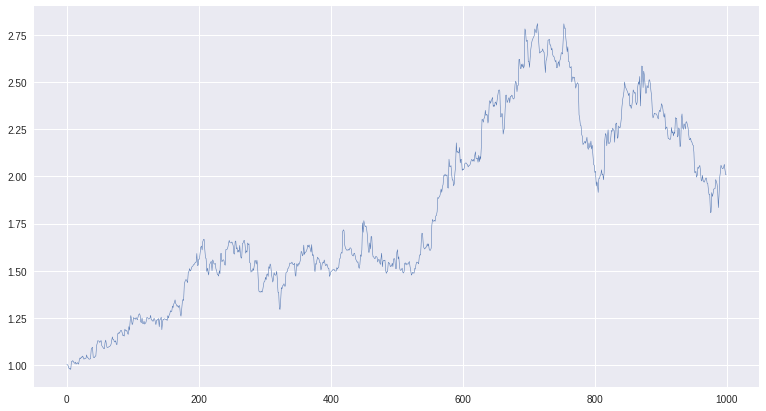

In [41]:
fig = plt.figure(figsize=(13,7))
plt.plot(path,lw=0.5)
plt.show()

In [0]:
def moving_average(path,window_size):
  return [np.mean(path[i-window_size+1:i+1]) for i in range(window_size-1,len(path))]

def rolling_vol(path,window_size):
  r = np.diff(path)/path[:-1]
  return [np.std(r[i-window_size+1:i+1]) for i in range(window_size-1,len(r))]
  
  
                                                              

In [0]:
windows = [13,26,52]
features = np.zeros([t+1,len(windows)*(len(windows)+3)//2+1])
features[1:,0] = np.diff(path)/path[:-1]

w = 1
for window in windows:
  features[window:,w] = np.diff(moving_average(path,window))/moving_average(path,window)[:-1]
  w += 1
for window in windows:
  features[window:,w] = rolling_vol(path,window)
  w += 1
for i in range(len(windows)-1):
  for j in range(i+1,len(windows)):
    features[windows[j]-1:,w] = np.array(moving_average(path,windows[j]))/np.array(moving_average(path,windows[i])[windows[j]-windows[i]:])-1





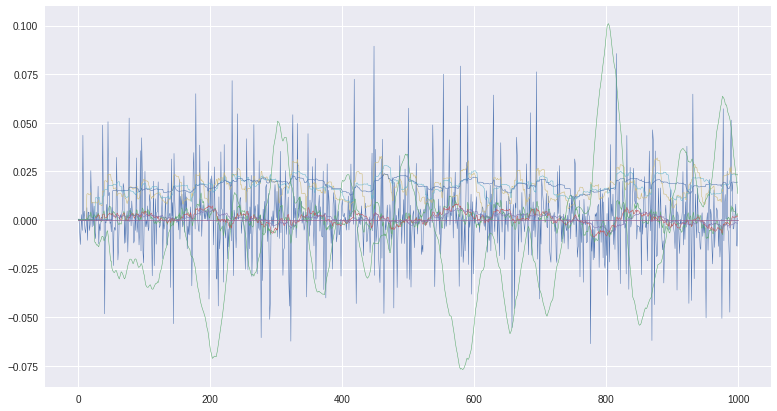

In [61]:
fig = plt.figure(figsize=(13,7))
plt.plot(features,lw=0.5)
plt.show()